To plot various learning 
conda env: /proj/data-eng/fsdp/train_env


== num_step=200
== start_step=0
== warmup_step=20 
==decay_steps_lengths: 40
== decay_start_step_absolute:160


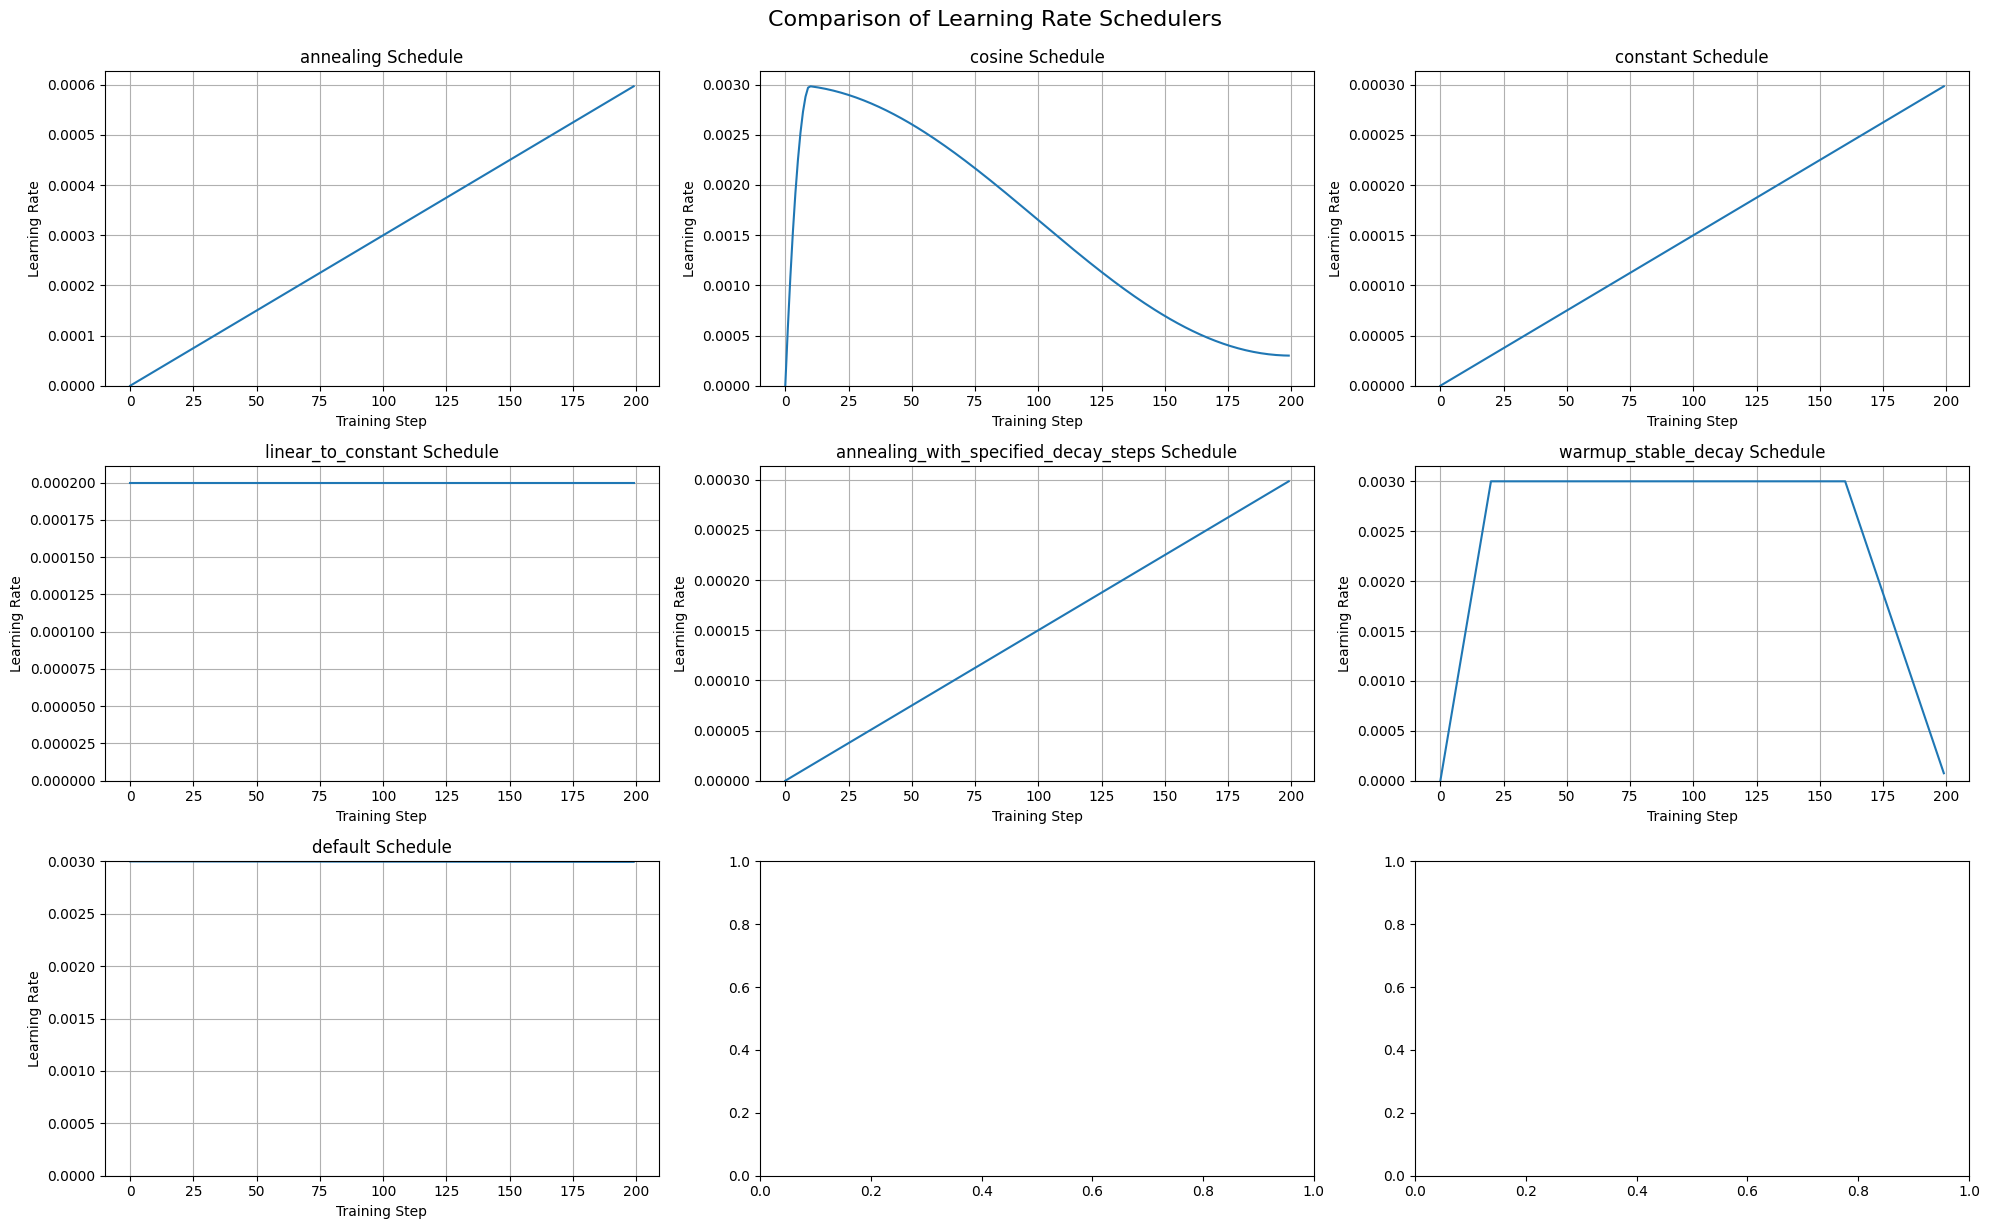

In [37]:
import matplotlib.pyplot as plt
import math
import torch
from torch.optim.lr_scheduler import LambdaLR

def get_learning_rate_data(num_steps, initial_learning_rate, training_stage, start_step=0):
    """
    Generates learning rate data over a specified number of steps for a given scheduler type.

    Args:
        num_steps (int): The total number of training steps.
        initial_learning_rate (float): The initial learning rate.
        training_stage (str): The type of scheduler (e.g., 'annealing', 'cosine').
        start_step (int): The starting step for the schedule, useful for resuming training.

    Returns:
        tuple: A tuple containing (list of steps, list of learning rates, title of the plot).
    """

    # Dummy optimizer
    optimizer = torch.optim.AdamW([torch.tensor([0.], requires_grad=True)], lr=initial_learning_rate)

    if training_stage == "annealing":
        warmup_interval = 1000
        schedule = lambda x: x / warmup_interval if x < warmup_interval else 1 - (x - warmup_interval) / (num_steps - warmup_interval)
    elif training_stage == "cosine":
        warmup_interval = min(2000, num_steps // 20)
        schedule = lambda x: min(
            1 - (1 - min(x, warmup_interval) / warmup_interval) ** 2,
            0.1
            + 0.5
            * (1 - 0.1)
            * (1 + math.cos(min(x, num_steps) / num_steps * math.pi)),
        )
    elif training_stage == "constant":
        warmup_interval = 2000
        schedule = lambda x: (min(x, warmup_interval) / warmup_interval)
    elif training_stage == "linear_to_constant":
        linear_steps = 25000
        start_lr_val = 2e-4
        end_lr_val = 2e-4
        schedule = lambda x: (start_lr_val + (end_lr_val - start_lr_val) * min(x - start_step, linear_steps) / linear_steps) / initial_learning_rate
    elif training_stage == "annealing_with_specified_decay_steps":
        warmup_interval = 2000
        total_decay_steps = 25000
        schedule = lambda x: (x - start_step) / warmup_interval if x - start_step < warmup_interval else max(0.0, 1 - (x - start_step - warmup_interval) / total_decay_steps)
    elif training_stage == "warmup_stable_decay":
        '''
        #== Ref. from SmoLM-135M at https://github.com/huggingface/smollm/blob/main/text/pretraining/smollm2/config_smollm2_135M.yaml
        == num_step=200
        == start_step=170
        == warmup_step=20 
        ==decay_steps_lengths: 40
        == decay_start_step_absolute:160
        '''
        warmup_steps = 20 
        decay_start_fraction = 0.8 # Decay starts for the last 20% of steps

        decay_start_step_absolute = int(num_steps * decay_start_fraction)
        decay_steps_length = num_steps - decay_start_step_absolute
        
        assert decay_start_step_absolute > warmup_steps, f"The decay_start_step_absolute {decay_start_step_absolute:,} cannot be smaller than warmup_step {warmup_steps:,} given  the num_step={num_steps:,}"   
        
        print(f"\n== num_step={num_steps:,}\n== start_step={start_step:,}\n== warmup_step={warmup_steps:,} \n==decay_steps_lengths: {decay_steps_length:,}\n== decay_start_step_absolute:{decay_start_step_absolute:,}")     

        # x is the current step (0 to num_steps-1):
        schedule = lambda x: (
            x / warmup_steps if x < warmup_steps
            else (
                1.0 if x < decay_start_step_absolute
                else max(0.0, 1.0 - (x - decay_start_step_absolute) / decay_steps_length)
            )
        )
    elif training_stage == "default":
        schedule = lambda x: 1.0 + (0.75 - 1.0) * (x / 32000) if x <= 32000 else 0.75
    else:
        raise ValueError(f"Invalid training_stage: {training_stage}!")

    scheduler = LambdaLR(optimizer, lr_lambda=lambda x: schedule(x + start_step))

    lrs = []
    steps_list = []
    for step in range(start_step,num_steps):
        optimizer.param_groups[0]['lr'] = initial_learning_rate
        lrs.append(optimizer.param_groups[0]['lr'] * scheduler.get_last_lr()[0] / initial_learning_rate)
        scheduler.step()
        steps_list.append(step)

    return steps_list, lrs, training_stage

# --- Plotting all the schedulers in subplots ---

#NUM_STEPS = 2_000_000 
NUM_STEPS = 200 
INITIAL_LR = 3*1e-3 

training_stages_to_plot = [
    "annealing",
    "cosine",
    "constant",
    "linear_to_constant",
    "annealing_with_specified_decay_steps",
    "warmup_stable_decay", 
    "default"
]

# 3 rows, 3 columns
fig, axes = plt.subplots(3, 3, figsize=(20, 12)) 
axes = axes.flatten() 
start_step=0
for i, stage in enumerate(training_stages_to_plot):
    steps_list, lrs, title = get_learning_rate_data(NUM_STEPS, INITIAL_LR, stage, start_step=start_step)
    ax = axes[i] 

    ax.plot(steps_list, lrs)
    ax.set_title(f"{title} Schedule", fontsize=12)
    ax.set_xlabel("Training Step", fontsize=10)
    ax.set_ylabel("Learning Rate", fontsize=10)
    ax.grid(True)
    ax.set_ylim(bottom=0) 


plt.tight_layout()
plt.suptitle("Comparison of Learning Rate Schedulers", fontsize=16, y=1.02)
plt.show()

In [34]:
steps_list, lrs, title = get_learning_rate_data(NUM_STEPS, INITIAL_LR, "warmup_stable_decay", start_step=170)
len(steps_list), len(lrs)
for s,lr in enumerate(zip(steps_list, lrs)):
    print(f"{s}: {lr}")


== num_step=200
== start_step=170
== warmup_step=20 
==decay_steps_lengths: 40
== decay_start_step_absolute:160
<function get_learning_rate_data.<locals>.<lambda> at 0x7f1a870027a0>
0: (0, 0.0022500000000000003)
1: (1, 0.002175)
2: (2, 0.0021)
3: (3, 0.0020250000000000003)
4: (4, 0.0019500000000000001)
5: (5, 0.0018749999999999997)
6: (6, 0.0018)
7: (7, 0.0017250000000000002)
8: (8, 0.0016500000000000002)
9: (9, 0.0015750000000000002)
10: (10, 0.0015)
11: (11, 0.0014250000000000003)
12: (12, 0.0013499999999999999)
13: (13, 0.001275)
14: (14, 0.0012000000000000001)
15: (15, 0.0011250000000000001)
16: (16, 0.00105)
17: (17, 0.0009749999999999998)
18: (18, 0.0009000000000000003)
19: (19, 0.0008250000000000001)
20: (20, 0.00075)
21: (21, 0.0006749999999999999)
22: (22, 0.0005999999999999998)
23: (23, 0.0005250000000000002)
24: (24, 0.00045000000000000015)
25: (25, 0.000375)
26: (26, 0.0002999999999999999)
27: (27, 0.00022499999999999986)
28: (28, 0.00015000000000000015)
29: (29, 7.5000000

/proj/data-eng/fsdp/train_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
